### Mnist分类任务：

- 网络基本构建与训练方法，常用函数解析

- torch.nn.functional模块

- nn.Module模块


### 读取Mnist数据集
- 会自动进行下载

In [1]:
%matplotlib inline



读取数据

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

784是mnist数据集每个样本的像素点个数

(50000, 784)


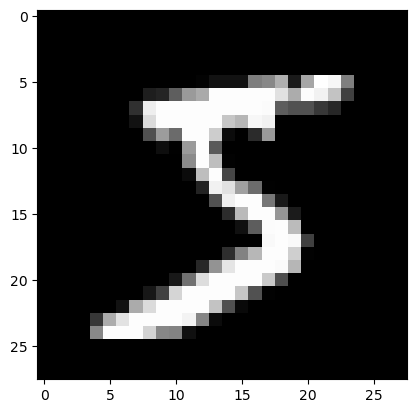

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

<img src="./img/4.png" alt="FAO" width="790">

<img src="./img/5.png" alt="FAO" width="790">

注意数据需转换成tensor才能参与后续建模训练


In [5]:
import torch
# 将数据都转化成Torch数据
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### torch.nn.functional 很多层和函数在这里都会见到

torch.nn.functional中有很多功能，后续会常用的。那什么时候使用nn.Module，什么时候使用nn.functional呢？一般情况下，如果模型有可学习的参数，最好用nn.Module，其他情况nn.functional相对更简单一些

In [6]:
import torch.nn.functional as F

# 使用交叉熵的方式计算loss函数
loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

In [7]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
xb.shape

torch.Size([64, 784])

In [8]:
bs = 64
xb = x_train[0:bs]  # a mini-batch from x
yb = y_train[0:bs]
weights = torch.randn([784, 10], dtype = torch.float,  requires_grad = True) 
bs = 64
bias = torch.zeros(10, requires_grad=True)

# 
print(loss_func(model(xb), yb))

tensor(13.2326, grad_fn=<NllLossBackward0>)


### 创建一个model来更简化代码

- 必须继承nn.Module且在其构造函数中需调用nn.Module的构造函数
- 无需写反向传播函数，nn.Module能够利用autograd自动实现反向传播
- Module中的可学习参数可以通过named_parameters()或者parameters()返回迭代器

In [9]:
from torch import nn
# 继承nn.Module
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(784, 128)
        self.hidden2 = nn.Linear(128, 256)
        self.out  = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.out(x)
        return x
        

In [10]:
net = Mnist_NN()
print(net)


Mnist_NN(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
print(list(net.named_parameters()))


[('hidden1.weight', Parameter containing:
tensor([[-0.0039, -0.0199, -0.0283,  ..., -0.0031, -0.0331, -0.0093],
        [-0.0146, -0.0272, -0.0232,  ..., -0.0113, -0.0247,  0.0084],
        [-0.0046,  0.0346, -0.0145,  ..., -0.0149,  0.0246,  0.0147],
        ...,
        [ 0.0266,  0.0188,  0.0161,  ..., -0.0143, -0.0229, -0.0261],
        [-0.0042,  0.0055,  0.0312,  ...,  0.0167,  0.0302,  0.0309],
        [ 0.0122, -0.0295,  0.0123,  ..., -0.0056,  0.0222,  0.0074]],
       requires_grad=True)), ('hidden1.bias', Parameter containing:
tensor([ 0.0240,  0.0285, -0.0067,  0.0135, -0.0247, -0.0292,  0.0099,  0.0246,
         0.0210, -0.0350, -0.0320, -0.0158, -0.0045, -0.0337, -0.0188, -0.0037,
        -0.0043,  0.0259,  0.0161, -0.0013, -0.0021,  0.0104, -0.0137,  0.0194,
         0.0354, -0.0340, -0.0315,  0.0351,  0.0195,  0.0327,  0.0273, -0.0353,
         0.0158, -0.0264,  0.0225,  0.0239,  0.0166,  0.0327,  0.0344,  0.0068,
        -0.0178,  0.0112, -0.0063,  0.0002,  0.0218, -0.

可以打印我们定义好名字里的权重和偏置项

In [12]:
for name, parameter in net.named_parameters():
    print(name, parameter,parameter.size())

hidden1.weight Parameter containing:
tensor([[-0.0039, -0.0199, -0.0283,  ..., -0.0031, -0.0331, -0.0093],
        [-0.0146, -0.0272, -0.0232,  ..., -0.0113, -0.0247,  0.0084],
        [-0.0046,  0.0346, -0.0145,  ..., -0.0149,  0.0246,  0.0147],
        ...,
        [ 0.0266,  0.0188,  0.0161,  ..., -0.0143, -0.0229, -0.0261],
        [-0.0042,  0.0055,  0.0312,  ...,  0.0167,  0.0302,  0.0309],
        [ 0.0122, -0.0295,  0.0123,  ..., -0.0056,  0.0222,  0.0074]],
       requires_grad=True) torch.Size([128, 784])
hidden1.bias Parameter containing:
tensor([ 0.0240,  0.0285, -0.0067,  0.0135, -0.0247, -0.0292,  0.0099,  0.0246,
         0.0210, -0.0350, -0.0320, -0.0158, -0.0045, -0.0337, -0.0188, -0.0037,
        -0.0043,  0.0259,  0.0161, -0.0013, -0.0021,  0.0104, -0.0137,  0.0194,
         0.0354, -0.0340, -0.0315,  0.0351,  0.0195,  0.0327,  0.0273, -0.0353,
         0.0158, -0.0264,  0.0225,  0.0239,  0.0166,  0.0327,  0.0344,  0.0068,
        -0.0178,  0.0112, -0.0063,  0.0002, 

### 使用TensorDataset和DataLoader来简化

In [13]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [14]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

- 一般在训练模型时加上model.train()，这样会正常使用Batch Normalization和 Dropout
- 测试的时候一般选择model.eval()，这样就不会使用Batch Normalization和 Dropout

In [15]:
import numpy as np

def fit(steps, model, loss_func, opt, train_dl, valid_dl):
    for step in range(steps):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print('当前step:'+str(step), '验证集损失：'+str(val_loss))

In [16]:
from torch import optim
def get_model():
    model = Mnist_NN()
    return model, optim.Adam(model.parameters(), lr=0.001)

In [17]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

### 三行搞定！

In [18]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(25, model, loss_func, opt, train_dl, valid_dl)

当前step:0 验证集损失：0.14866696909070015
当前step:1 验证集损失：0.10762357178330421
当前step:2 验证集损失：0.09148775678351521
当前step:3 验证集损失：0.09239266448542476
当前step:4 验证集损失：0.09119845449198037
当前step:5 验证集损失：0.09368460708372295
当前step:6 验证集损失：0.09543108020629734
当前step:7 验证集损失：0.12964335346361622
当前step:8 验证集损失：0.1064905257988372
当前step:9 验证集损失：0.0952181197460508
当前step:10 验证集损失：0.09992968667526002
当前step:11 验证集损失：0.1093115426942466
当前step:12 验证集损失：0.1053862185144244
当前step:13 验证集损失：0.13352388969183956
当前step:14 验证集损失：0.12262713425904731
当前step:15 验证集损失：0.12021054504886251
当前step:16 验证集损失：0.13394502818775944
当前step:17 验证集损失：0.1302742688085876
当前step:18 验证集损失：0.13685556791070835
当前step:19 验证集损失：0.13136188031951315
当前step:20 验证集损失：0.13773769891970727
当前step:21 验证集损失：0.14880260401972592
当前step:22 验证集损失：0.13825004334147087
当前step:23 验证集损失：0.13655680389303015
当前step:24 验证集损失：0.16287535354070132
